In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.models.video as video_models
import albumentations as A
from pathlib import Path
from tqdm import tqdm


/Users/jenishkothari/Northeastern/CS6140/Automatic Highlight Generation/myenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
CONFIG = {
    'frame_height': 224,
    'frame_width': 224,
    'num_frames': 32,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'video_dir': '../data/extracted',  # <-- change this if needed
    'classes': ['Goal', 'Foul','Red card']
}


In [6]:
def process_video(video_path, config):
    cap = cv2.VideoCapture(str(video_path))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = np.linspace(0, frame_count - 1, config['num_frames'], dtype=int)

    basic_transform = A.Compose([
        A.Resize(height=config['frame_height'], width=config['frame_width']),
        A.Normalize(mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989])
    ])

    frames = []
    for i in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = basic_transform(image=frame)['image']
        frames.append(frame)

    cap.release()

    if len(frames) == 0:
        return None

    frames = np.array(frames)
    frames = np.transpose(frames, (3, 0, 1, 2))  # [T, H, W, C] -> [C, T, H, W]
    return torch.from_numpy(frames).unsqueeze(0).float().to(config['device'])  # Add batch dim


In [7]:
class SimpleR3DClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleR3DClassifier, self).__init__()
        self.r3d = video_models.r3d_18(pretrained=True)
        in_features = self.r3d.fc.in_features
        self.r3d.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.r3d(x)

model = SimpleR3DClassifier(num_classes=len(CONFIG['classes']))
model.to(CONFIG['device'])
model.eval()


/Users/jenishkothari/Northeastern/CS6140/Automatic Highlight Generation/myenv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jenishkothari/Northeastern/CS6140/Automatic Highlight Generation/myenv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /Users/jenishkothari/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:01<00:00, 79.1MB/s] 


SimpleR3DClassifier(
  (r3d): VideoResNet(
    (stem): BasicStem(
      (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (conv2): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=

In [8]:
label_to_idx = {label: i for i, label in enumerate(CONFIG['classes'])}
idx_to_label = {i: label for label, i in label_to_idx.items()}

y_true = []
y_pred = []

# Loop over each class folder
for class_name in CONFIG['classes']:
    class_dir = Path(CONFIG['video_dir']) / class_name
    video_files = list(class_dir.glob('*.mp4'))

    print(f"Evaluating {class_name} ({len(video_files)} videos)")
    
    for video_path in tqdm(video_files):
        tensor = process_video(video_path, CONFIG)
        if tensor is None:
            continue

        with torch.no_grad():
            output = model(tensor)
            probs = torch.nn.functional.softmax(output, dim=1)
            pred = torch.argmax(probs, dim=1).item()

        y_true.append(label_to_idx[class_name])
        y_pred.append(pred)


Evaluating Goal (100 videos)


100%|██████████| 100/100 [05:26<00:00,  3.26s/it]


Evaluating Foul (100 videos)


100%|██████████| 100/100 [04:43<00:00,  2.84s/it]


Evaluating Red card (4 videos)


100%|██████████| 4/4 [00:13<00:00,  3.42s/it]



✅ Accuracy: 3.92%

Classification Report:
              precision    recall  f1-score   support

        Goal       0.25      0.08      0.12       100
        Foul       0.00      0.00      0.00       100
    Red card       0.00      0.00      0.00         4

    accuracy                           0.04       204
   macro avg       0.08      0.03      0.04       204
weighted avg       0.12      0.04      0.06       204



/Users/jenishkothari/Northeastern/CS6140/Automatic Highlight Generation/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jenishkothari/Northeastern/CS6140/Automatic Highlight Generation/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jenishkothari/Northeastern/CS6140/Automatic Highlight Generation/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with

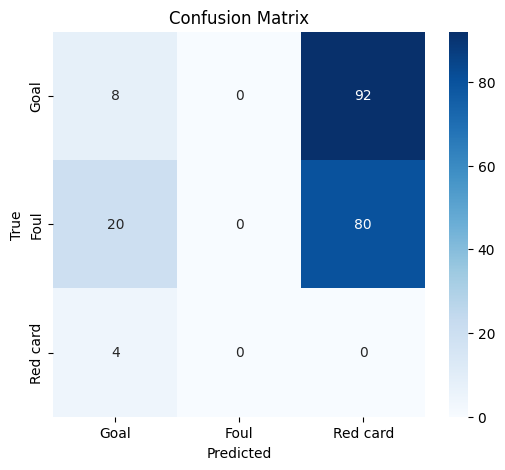

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Accuracy: {acc*100:.2f}%")

# Print full classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=CONFIG['classes']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CONFIG['classes'], yticklabels=CONFIG['classes'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
